# Lecture : Graph Generation Models

## Lab 03 : WGAN model for mixture of Gaussians

### Xavier Bresson, Nian Liu


In [1]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    path_to_file = '/content/gdrive/My Drive/CS5284_2024_codes/codes/11_Graph_Generation'
    print(path_to_file)
    # change current path to the folder containing "path_to_file"
    os.chdir(path_to_file)
    !pwd
    

In [2]:
# Libraries
import torch
import torch.nn as nn
import torch.optim as optim
import time
#import utils
import matplotlib.pyplot as plt
import logging
logging.getLogger().setLevel(logging.CRITICAL) # remove warnings
import os, datetime

# PyTorch version and GPU
print(torch.__version__)
if torch.cuda.is_available():
  print(torch.cuda.get_device_name(0))
  device= torch.device("cuda:0") # use GPU
else:
  device= torch.device("cpu")
print(device)


2.0.1+cu118
NVIDIA GeForce RTX 4090 Laptop GPU
cuda:0


/home/bcjr1997/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


# Create artifical dataset of mixture of Gaussians

num_x, range_x, step_x, x :  100 20 0.40404040404040403 torch.Size([100])
num_gaussians :  2
train_data, bs, num_batch :  torch.Size([4000, 100]) 100 40
train_data :  torch.Size([4000, 100])
max, min, mean :  tensor(1.) tensor(-1.) tensor(-0.7510)


<Figure size 432x288 with 0 Axes>

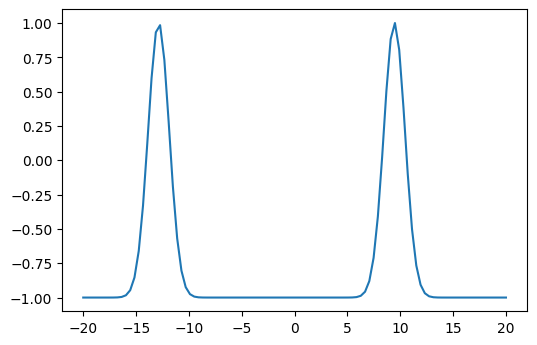

<Figure size 432x288 with 0 Axes>

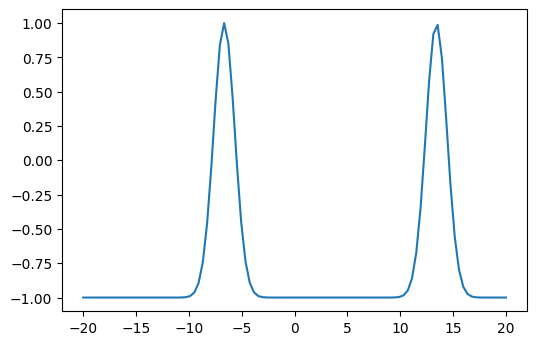

In [3]:
# Parameters of the mixture of Gaussians
num_data = 4000
num_x = 100
range_x = 20
step_x = 2 * range_x / (num_x - 1)
x = torch.arange(-range_x,range_x+step_x,step_x)
print('num_x, range_x, step_x, x : ',num_x, range_x, step_x, x.size())
num_gaussians = 2
print('num_gaussians : ', num_gaussians)
train_data = torch.zeros(num_data, num_x)
bs = 100
num_batch = num_data//bs
print('train_data, bs, num_batch : ', train_data.size(), bs, num_batch)

for k in range(num_batch):
    mu = torch.zeros(num_gaussians, bs)
    mu[0,:] = torch.FloatTensor(bs).uniform_(-15, -5)
    mu[1,:] = torch.FloatTensor(bs).uniform_(5, 15)   
    mu_batch = mu.unsqueeze(2)
    sigma = torch.ones(num_gaussians, bs)
    sigma_batch = sigma.unsqueeze(2)
    x_batch = x.repeat(num_gaussians, bs, 1)
    p = torch.exp( - (x_batch - mu_batch)**2 / (2* sigma_batch**2) ) / torch.sqrt( 2* torch.pi* sigma_batch**2 )
    p = p.sum(0); p /= p.sum(1).unsqueeze(1)
    p = ( p - p.min(1)[0].unsqueeze(1) ) / ( p.max(1)[0].unsqueeze(1) - p.min(1)[0].unsqueeze(1) )
    p = 2 * ( p - 0.5 )
    train_data[k*bs:(k+1)*bs, :] = p
print('train_data : ',train_data.size())
print('max, min, mean : ',train_data.max(), train_data.min(), train_data.mean())

plt.figure(2)
plt.figure(dpi=100)
plt.plot(x, train_data[0])
plt.show()
plt.figure(3)
plt.figure(dpi=100)
plt.plot(x, train_data[1])
plt.show()


# Design the class of WGAN model [1,2,3] with Transformers [4] 

[1] Goodfellow et-al, Generative Adversarial Networks, 2014, https://arxiv.org/pdf/1406.2661  
[2] Arjovsky et-al, Wasserstein GAN, 2017, https://arxiv.org/pdf/1701.07875  
[3] Gulrajani et-al, Improved Training of Wasserstein GANs, 2017, https://arxiv.org/pdf/1704.00028  
[4] Vaswani et-al, Attention Is All You Need, 2017, https://arxiv.org/pdf/1706.03762    



In [4]:
# Global constants
N = train_data.size(0) # number of training data
n = train_data.size(1) # number of elements in the line 
print('N, n : ', N, n)

dz = 16 # number of dimensions for the compressed representation
num_heads = 4 # number of heads in the transformer layer
d = 32 * num_heads # number of hidden dimensions
num_layers_discriminator = 2 # number of transformer discriminator layers
num_layers_generator = 2 # number of transformer generator layers
drop = 0.0 # dropout value
dropout_dis = 0.05 # dropout value for the discriminator network
bs = 50 # batch size
print('dz, num_heads, d, num_layers_discriminator, num_layers_generator, drop, dropout_dis, bs : ', \
      dz, num_heads, d, num_layers_discriminator, num_layers_generator, drop, dropout_dis, bs)


N, n :  4000 100
dz, num_heads, d, num_layers_discriminator, num_layers_generator, drop, dropout_dis, bs :  16 4 128 2 2 0.0 0.05 50


In [5]:
# Define WGAN architecture with Transformers
class head_attention(nn.Module):
    def __init__(self, d, d_head):
        super().__init__()
        self.Q = nn.Linear(d, d_head)
        self.K = nn.Linear(d, d_head)
        self.V = nn.Linear(d, d_head)
        self.sqrt_d = torch.sqrt(torch.tensor(d_head))
        self.drop_att = nn.Dropout(drop)
    def forward(self, x):
        Q = self.Q(x)      # [bs, n, d_head]
        K = self.K(x)      # [bs, n, d_head]
        V = self.V(x)      # [bs, n, d_head]
        Q = Q.unsqueeze(2) # [bs, n, 1, d_head]
        K = K.unsqueeze(1) # [bs, 1, n, d_head]
        Att = (Q * K).sum(dim=3) / self.sqrt_d # [bs, n, n]
        Att = torch.softmax(Att, dim=1)        # [bs, n, n]
        Att = self.drop_att(Att) # [bs, n, d_head]
        x = Att @ V              # [bs, n, d_head]
        return x

class MHA(nn.Module):
    def __init__(self, d, num_heads):  
        super().__init__()
        d_head = d // num_heads
        self.heads = nn.ModuleList( [head_attention(d, d_head) for _ in range(num_heads)] )
        self.WOx = nn.Linear(d, d)
        self.drop_x = nn.Dropout(drop)
    def forward(self, x):
        x_MHA = []  
        for head in self.heads:
            x_HA = head(x)     # [bs, n, d_head]
            x_MHA.append(x_HA)
        x = self.WOx(torch.cat(x_MHA, dim=2)) # [bs, n, d]
        x = self.drop_x(x)                    # [bs, n, d]
        return x

class BlockGT(nn.Module):
    def __init__(self, d, num_heads):  
        super().__init__()
        self.LNx = nn.LayerNorm(d)
        self.LNx2 = nn.LayerNorm(d)
        self.MHA = MHA(d, num_heads)
        self.MLPx = nn.Sequential(nn.Linear(d, 4*d), nn.LeakyReLU(), nn.Linear(4*d, d))
        self.drop_x_mlp = nn.Dropout(drop)
        self.mu = nn.Linear(d, d, bias=True)
    def forward(self, x):
        x_in = x                        # [bs, n, d]
        x = self.LNx(x)                 # [bs, n, d]
        x_MHA = self.MHA(x)             # [bs, n, d]
        x = x_in + x_MHA                # [bs, n, d]
        x = x + self.MLPx(self.LNx2(x)) # [bs, n, d]
        x = self.drop_x_mlp(x)          # [bs, n, d]
        return x

# Question 1: Implement the WGAN architecture

#### Step 1: Construct the generator
- Build the generator network using `BlockGT`.
- Map noise `z` into features for each data point.
- Go through the generator network.
- Map the output data embedding into the generated data. \
Notice the usage of `LayerNorm`.

#### Step 2: Define the discriminator
- Build the discriminator network using `BlockGT`.
- Go through the discriminator network.
- According to all output data embeddings, predict the discriminator value of the given input sample. \

Notices:
- The number of layers of generator and discriminator can be the same.
- The dropout layer is used after each layer of the discriminator.

#### Step 3: Design WGAN
Initialize the generator and the discriminator, and code their forward process.


In [6]:
class generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_z = nn.Linear(dz, n*d)
        self.ln_h = nn.LayerNorm(n*d)
        ###############################################
        # Initialize generator network
        # YOUR CODE STARTS
        ###############################################
        self.gt_gen_layers = nn.ModuleList([BlockGT(d, num_heads) for _ in range(num_layers_generator)])
        ###############################################
        # YOUR CODE ENDS
        ###############################################
        self.ln_final = nn.LayerNorm(d)  
        self.linear_final = nn.Linear(d, 1)
    def forward(self, z, pe):  
        # input layer
        ###############################################
        # noise z -> initial features for data points
        # YOUR CODE STARTS
        ###############################################
        h = self.linear_z(z) # [bs, n*d] 
        ###############################################
        # YOUR CODE ENDS
        ###############################################
        h = self.ln_h(h) # [bs, n*d] 
        h = nn.LeakyReLU()(h) # [bs, n*d] 
        bs2 = h.size(0)
        h = h.view(bs2, n, d) # [bs, n, d]
        h = h + pe[:bs2,:,:] # [bs, n, d]
        ###############################################
        # Go through generator
        # YOUR CODE STARTS
        ###############################################
        # L layers
        for layer in self.gt_gen_layers:
            h = layer(h)
        ###############################################
        # YOUR CODE ENDS
        ###############################################
        # output    
        h = nn.LeakyReLU()(h)
        h = self.ln_final(h)# [bs, n, d] 
        ###############################################
        # embedding h -> generated data
        # YOUR CODE STARTS
        ###############################################
        h = self.linear_final(h).squeeze() # [bs, n] 
        ###############################################
        # YOUR CODE ENDS
        ###############################################
        return h

class discriminator(nn.Module):
    def __init__(self):
        super().__init__()   
        self.h_emb = nn.Linear(1, d)
        ###############################################
        # Initialize discriminator network and dropout layers
        # YOUR CODE STARTS
        ###############################################
        self.gt_dis_layers = nn.ModuleList([BlockGT(d, num_heads) for _ in range(num_layers_discriminator)])
        self.dp_dis_layers = nn.ModuleList([nn.Dropout(dropout_dis) for _ in range(num_layers_discriminator)])
        ###############################################
        # YOUR CODE ENDS
        ############################################### 
        self.linear_out = nn.Linear(n*d, 1)   
    def forward(self, h, pe): 
        # input layer
        h = self.h_emb(h.unsqueeze(2)) # [bs, n, d]
        h = h + pe                     # [bs, n, d] 
        ###############################################
        # Go through discriminator
        # YOUR CODE STARTS
        ###############################################
        # L layers
        for gt_dis_layer, dp_dis_layer in zip(self.gt_dis_layers, self.dp_dis_layers): 
            h = gt_dis_layer(h)       # [bs, n, d]
            h = dp_dis_layer(h)        # [bs, n, d]
        ###############################################
        # YOUR CODE ENDS
        ############################################### 
        # output
        h = h.contiguous().view(bs, n*d)# [bs, n*d]
        ###############################################
        # Predict the truth of the input `h`
        # YOUR CODE STARTS
        ###############################################
        h = self.linear_out(h)# [bs, 1]
        ###############################################
        # YOUR CODE ENDS
        ############################################### 
        return h

class WGAN(nn.Module):
    def __init__(self):
        super().__init__()
        self.pe_x = nn.Embedding(n, d)
        self.generator = generator()
        self.discriminator = discriminator()
    def forward_gen(self, z):
        pe = torch.arange(0,n).to(device).repeat(bs,1) # [bs, n] 
        pe = self.pe_x(pe) # [bs, n, d] 
        ###############################################
        # YOUR CODE STARTS
        ###############################################
        g_z = self.generator(z, pe)
        ###############################################
        # YOUR CODE ENDS
        ############################################### 
        return g_z
    def forward_dis(self, h):
        pe = torch.arange(0,n).to(device).repeat(bs,1) # [bs, n] 
        pe = self.pe_x(pe) # [bs, n, d] 
        ###############################################
        # YOUR CODE STARTS
        ###############################################
        d_h = self.discriminator(h, pe)
        ###############################################
        # YOUR CODE ENDS
        ############################################### 
        return d_h

# Question 2: Code the training pipeline of WGAN, including optimizer, loss, and backward pass

Hints:
- Separate the parameters from the generator and the discriminator, and set different optimizers for them.
- Training losses for the generator and the discriminator are as follows:
\begin{eqnarray*}
    &&\quad\quad\ \textrm{Discriminator Loss: } \mathbb{L}_D(\phi)=\mathbb{E}(D_\phi(x_{real}))-\mathbb{E}(D_\phi(x_{gen}))+\lambda(||\bigtriangledown_{\hat{x}}D_\phi(\hat{x})||_2-1)\\
&&\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\ \textrm{where } \hat{x}=\epsilon x_{real}+(1-\epsilon)x_{gen}, \epsilon\sim\mathcal{N}(0, I)\\
&&\quad\quad\ \textrm{Generator Loss: } \mathbb{L}_G(\theta)=-\mathbb{E}(D_\phi(x_{gen}))=-\mathbb{E}(D_\phi(G_\theta(z)))
\end{eqnarray*}

For the discriminator loss, use [torch.autograd.grad(outputs, inputs, grad_outputs, create_graph)](https://pytorch.org/docs/stable/generated/torch.autograd.grad.html) to get the gradient of `outputs` over `inputs`.   
`grad_outputs` lets you specify the gradient values at the output tensor to propagate backward.   
`create_graph=True` allows us to use the gradients as part of the loss.


In [7]:
# Instantiate the network
net = WGAN()
net = net.to(device)
def display_num_param(net):
    nb_param = 0
    for param in net.parameters():
        nb_param += param.numel()
    print('Number of parameters: {} ({:.2f} million)'.format(nb_param, nb_param/1e6))
_ = display_num_param(net)

# Test the forward pass, backward pass and gradient update with a single batch
init_lr = 0.001
###############################################
# Separate parameters, define different optimizers
# YOUR CODE STARTS
###############################################
gen_params = []
for p in net.generator.parameters():
    gen_params.append(p)
for p in net.pe_x.parameters():
    gen_params.append(p)
gen_params = nn.ParameterList(gen_params)
dis_params = []
for p in net.discriminator.parameters():
    dis_params.append(p)
for p in net.pe_x.parameters():
    dis_params.append(p)
dis_params = nn.ParameterList(dis_params)
optimizer_g = torch.optim.Adam(gen_params, init_lr)
optimizer_d = torch.optim.Adam(dis_params, init_lr)
###############################################
# YOUR CODE ENDS
###############################################

idx_data = torch.LongTensor(bs).random_(0,N)
x_real = train_data[idx_data,:].to(device) # [bs, n]
print('x_real',x_real.size())
z = torch.rand(bs, dz).to(device) # [bs, dz]
print('z',z.size())

x_fake = net.forward_gen(z) # [bs, n]
print('x_fake',x_fake.size())
fake_discr = net.forward_dis(x_fake) # [bs, 1]    
real_discr = net.forward_dis(x_real) # [bs, 1]
print('fake_discr',fake_discr.size())
print('real_discr',real_discr.size())

###############################################
# Calculate discriminator loss, and back propagate
# YOUR CODE STARTS
###############################################
# Calculate x_hat
epsilon = torch.FloatTensor(bs, 1).uniform_(0, 1).to(device)
x_hat = epsilon * x_real + (1 - epsilon) * x_fake # X_hat
xhat_discr = net.forward_dis(x_hat) # D_phi(x_hat)
# Get the gradients of D_phi(x_hat)
grads = torch.autograd.grad(xhat_discr, x_hat, grad_outputs=torch.ones_like(xhat_discr), create_graph=True)[0]
penalty = ((torch.sqrt((grads ** 2).sum(1)) - 1) ** 2).mean()
loss = real_discr.mean() - fake_discr.mean()  # D_phi(x_real) - D_phi(x_fake)
loss = loss + 10 * penalty
optimizer_d.zero_grad()
loss.backward()
optimizer_d.step()
###############################################
# YOUR CODE ENDS
###############################################

z = torch.rand(bs, dz).to(device) # [bs, dz]
###############################################
# Calculate generator loss, and back propagate
# YOUR CODE STARTS
###############################################
loss = -1 * net.forward_dis(net.forward_gen(z)).mean()
optimizer_g.zero_grad()
loss.backward()
optimizer_g.step()
###############################################
# YOUR CODE ENDS
###############################################

Number of parameters: 1128578 (1.13 million)
x_real torch.Size([50, 100])
z torch.Size([50, 16])
x_fake torch.Size([50, 100])
fake_discr torch.Size([50, 1])
real_discr torch.Size([50, 1])


Number of parameters: 1128578 (1.13 million)
dz, num_heads, d, num_layers_discriminator, num_layers_generator, drop, dropout_dis, bs :  16 4 128 2 2 0.0 0.05 50
epoch= 0    time= 0.1366 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.02593    loss_g= 0.52469
epoch= 1    time= 0.2742 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.02094    loss_g= -0.7393
epoch= 2    time= 0.4168 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.04249    loss_g= -2.8304
epoch= 3    time= 0.5475 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.02794    loss_g= -5.7439
epoch= 4    time= 0.6747 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.01991    loss_g= -9.7843
epoch= 5    time= 0.8151 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.02137    loss_g= -15.488
epoch= 6    time= 0.9533 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.03192    loss_g= -17.824
epoch= 7    time= 1.0904 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.02221    loss_g= -18.722

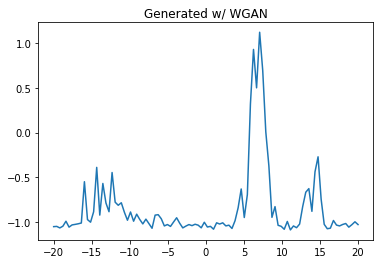

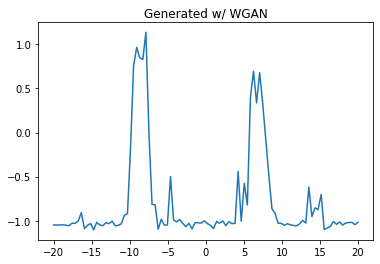

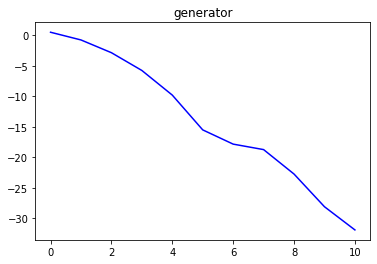

epoch= 11    time= 1.6320 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.00929    loss_g= -34.997
epoch= 12    time= 1.7652 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.01287    loss_g= -38.415
epoch= 13    time= 1.9001 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.00053    loss_g= -41.360
epoch= 14    time= 2.0344 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.00811    loss_g= -45.804
epoch= 15    time= 2.1686 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= -0.0047    loss_g= -48.901
epoch= 16    time= 2.3044 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.00531    loss_g= -51.869
epoch= 17    time= 2.4394 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.00496    loss_g= -55.755
epoch= 18    time= 2.5718 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.01077    loss_g= -59.377
epoch= 19    time= 2.7078 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.00134    loss_g= -62.917
epoch= 20    time= 2.8465 min    lr_d= 0.00030

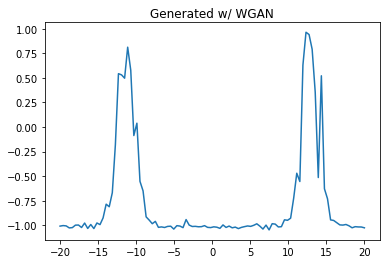

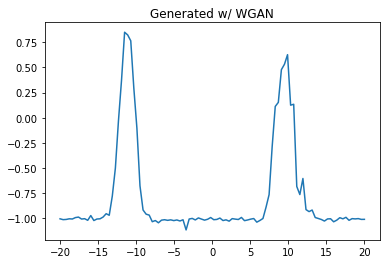

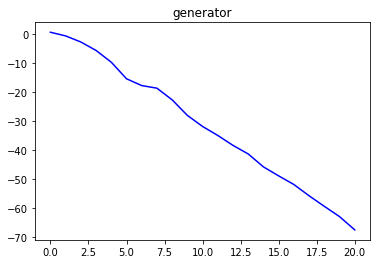

epoch= 21    time= 2.9867 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.00488    loss_g= -71.575
epoch= 22    time= 3.1242 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.00365    loss_g= -73.778
epoch= 23    time= 3.2592 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.00306    loss_g= -76.569
epoch= 24    time= 3.3968 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.00279    loss_g= -79.849
epoch= 25    time= 3.5336 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.00078    loss_g= -84.292
epoch= 26    time= 3.6694 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= -0.0004    loss_g= -88.659
epoch= 27    time= 3.7979 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= -0.0004    loss_g= -92.964
epoch= 28    time= 3.9332 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.00172    loss_g= -97.436
epoch= 29    time= 4.0666 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= -0.0019    loss_g= -100.93
epoch= 30    time= 4.1952 min    lr_d= 0.00030

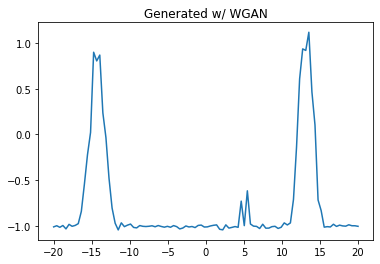

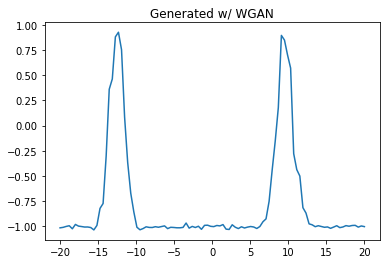

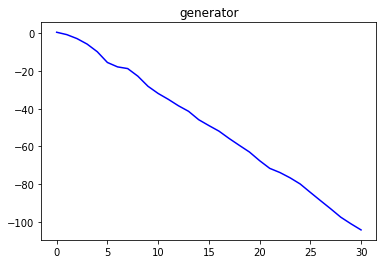

epoch= 31    time= 4.3302 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.00413    loss_g= -108.22
epoch= 32    time= 4.4651 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.00444    loss_g= -111.93
epoch= 33    time= 4.6007 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= -0.0016    loss_g= -116.41
epoch= 34    time= 4.7357 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.00142    loss_g= -120.40
epoch= 35    time= 4.8697 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= -0.0050    loss_g= -125.67
epoch= 36    time= 5.0027 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.00439    loss_g= -129.86
epoch= 37    time= 5.1378 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= -0.0005    loss_g= -134.72
epoch= 38    time= 5.2742 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= -0.0012    loss_g= -139.40
epoch= 39    time= 5.4101 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.00506    loss_g= -144.71
epoch= 40    time= 5.5460 min    lr_d= 0.00030

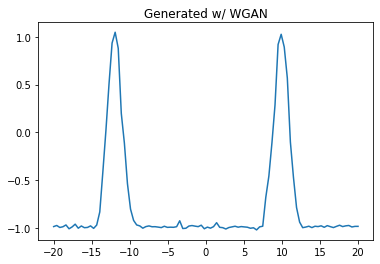

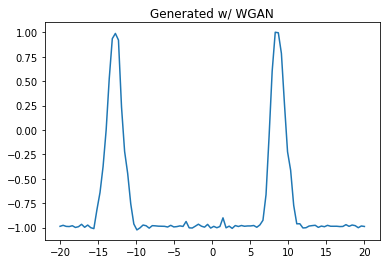

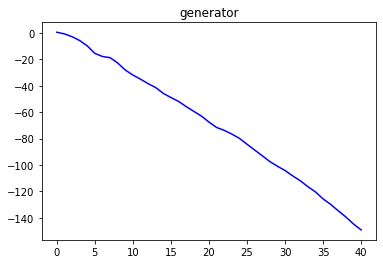

epoch= 41    time= 5.6869 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= -0.0024    loss_g= -153.98
epoch= 42    time= 5.8247 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.00394    loss_g= -156.90
epoch= 43    time= 5.9599 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= -0.0010    loss_g= -161.50
epoch= 44    time= 6.0971 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.00260    loss_g= -166.85
epoch= 45    time= 6.2435 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= -0.0020    loss_g= -169.41
epoch= 46    time= 6.3908 min    lr_d= 0.0003000    lr_g= 0.0003000    loss_d= 0.00455    loss_g= -172.62


KeyboardInterrupt: 

In [8]:
# Training loop
del net
net = WGAN()
net = net.to(device)
_ = display_num_param(net)

# Optimizer
list_param = []
for p in net.generator.parameters():
    list_param.append(p)
for p in net.pe_x.parameters():
    list_param.append(p)
params_gen = nn.ParameterList(list_param)
list_param = []
for p in net.discriminator.parameters():
    list_param.append(p)
for p in net.pe_x.parameters():
    list_param.append(p)
params_dis = nn.ParameterList(list_param)
init_lr = 0.0003
optimizer_g = torch.optim.Adam(params_gen, lr=init_lr, betas=(0.0, 0.9))
optimizer_d = torch.optim.Adam(params_dis, lr=init_lr, betas=(0.0, 0.9))
scheduler_g = optim.lr_scheduler.ReduceLROnPlateau(optimizer_g, mode='min', factor=0.95, patience=1, verbose=True)

print('dz, num_heads, d, num_layers_discriminator, num_layers_generator, drop, dropout_dis, bs : ', \
      dz, num_heads, d, num_layers_discriminator, num_layers_generator, drop, dropout_dis, bs)

# Number of mini-batches per epoch
nb_epochs = 100
run_every_k_steps = 5

list_loss_dis = []
list_loss_gen = []

start = time.time()
for epoch in range(nb_epochs):

    running_loss_d = 0.0
    running_loss_g = 0.0
    num_batches = 0

    net.train()
    
    shuffled_indices = torch.randperm(N)
    for count in range(0,N,bs):

        # discriminator update
        idx_real = shuffled_indices[count : count+bs]
        x_real = train_data[idx_real,:].to(device) # [bs, n]
        z = torch.rand(bs, dz).to(device) # [bs, dz]    
        x_fake = net.forward_gen(z) # [bs, n]
        fake_discr = net.forward_dis(x_fake) # [bs, 1]    
        real_discr = net.forward_dis(x_real) # [bs, 1]
        loss = fake_discr.mean() - real_discr.mean()
        epsilon = torch.FloatTensor(bs, 1).uniform_(0, 1).to(device)
        x_hat = epsilon * x_fake + (1 - epsilon) * x_real
        xhat_discr = net.forward_dis(x_hat)
        grads = torch.autograd.grad(xhat_discr, x_hat, grad_outputs=torch.ones_like(xhat_discr), create_graph=True)[0]
        penalty = ((torch.sqrt((grads ** 2).sum(1)) - 1) ** 2).mean()
        loss = loss + 10 * penalty
        running_loss_d = -loss.detach().cpu().item() 
        optimizer_d.zero_grad()
        loss.backward()
        optimizer_d.step()

        # generator update
        if count % run_every_k_steps == 0:
            z = torch.rand(bs, dz).to(device) # [bs, dz]
            loss = - net.forward_dis(net.forward_gen(z)).mean()
            optimizer_g.zero_grad()
            loss.backward()
            optimizer_g.step()
        running_loss_g += loss.detach().cpu().item() 

        # Compute stats
        num_batches += 1


    # Average stats
    mean_loss_d = running_loss_d/ num_batches
    mean_loss_g = running_loss_g/ num_batches
    if epoch>25:
        scheduler_g.step(mean_loss_g)
        optimizer_d.param_groups[0]['lr'] = optimizer_g.param_groups[0]['lr']
    elapsed = (time.time()-start)/60
    print('epoch=',epoch, '   time=', str(elapsed)[:6],'min', '   lr_d=', '{:.7f}'.format(optimizer_d.param_groups[0]['lr']) , \
          '   lr_g=', '{:.7f}'.format(optimizer_g.param_groups[0]['lr']) , \
          '   loss_d=', str(mean_loss_d)[:7] ,'   loss_g=', str(mean_loss_g)[:7] )
    list_loss_dis.append(mean_loss_d)
    list_loss_gen.append(mean_loss_g)

    # Plot intermediate generated data
    if not epoch%10 and epoch>0:
        plt.plot(x, x_fake[0].detach().cpu()); plt.title("Generated w/ WGAN"); plt.show()
        plt.plot(x, x_fake[1].detach().cpu()); plt.title("Generated w/ WGAN"); plt.show()
        # plt.plot(torch.tensor(list_loss_dis),'b-'); plt.title('discriminator'); plt.show() 
        plt.plot(torch.tensor(list_loss_gen),'b-'); plt.title('generator'); plt.show() 

    # Check lr value
    if optimizer_d.param_groups[0]['lr'] < 10**-5: 
      print("\n lr is equal to min lr -- training stopped\n")
      break




# Q3: Generate new data

Hints: 
- Sample noise `z` from uniform distribution. Use [torch.rand()](https://pytorch.org/docs/stable/generated/torch.rand.html#torch.rand).
- Pass through generator.

batch_x_0 torch.Size([50, 100])


<Figure size 1200x800 with 0 Axes>

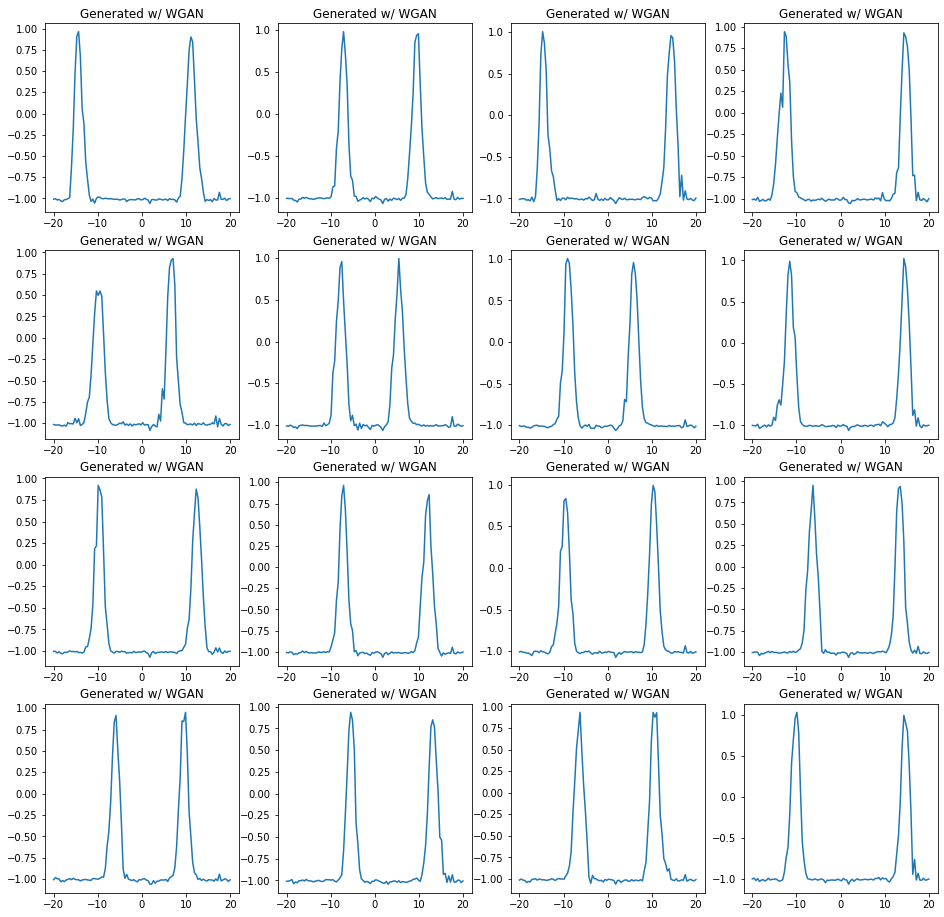

In [10]:
net.eval()
with torch.no_grad():
    num_generated_images = 16
    ###############################################
    # YOUR CODE STARTS
    ###############################################
    z = torch.rand(bs, dz).to(device)
    batch_x_0 = net.forward_gen(z)# [bs, n]
    ###############################################
    # YOUR CODE ENDS
    ###############################################
    print('batch_x_0',batch_x_0.size())
    batch_x_0 = batch_x_0.cpu()

plt.figure(1, dpi=200)
figure, axis = plt.subplots(4, 4)
figure.set_size_inches(16,16)
i,j,cpt=0,0,0; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ WGAN")
i,j,cpt=1,0,1; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ WGAN")
i,j,cpt=2,0,2; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ WGAN")
i,j,cpt=3,0,3; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ WGAN")
i,j,cpt=0,1+0,4; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ WGAN")
i,j,cpt=1,1+0,5; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ WGAN")
i,j,cpt=2,1+0,6; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ WGAN")
i,j,cpt=3,1+0,7; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ WGAN")
i,j,cpt=0,2+0,8; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ WGAN")
i,j,cpt=1,2+0,9; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ WGAN")
i,j,cpt=2,2+0,10; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ WGAN")
i,j,cpt=3,2+0,11; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ WGAN")
i,j,cpt=0,3+0,12; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ WGAN")
i,j,cpt=1,3+0,13; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ WGAN")
i,j,cpt=2,3+0,14; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ WGAN")
i,j,cpt=3,3+0,15; axis[i,j].plot(x, batch_x_0[cpt]); axis[i,j].set_title("Generated w/ WGAN")
plt.show()
